# 1. 데이터 준비

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 구성

In [2]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    test_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    test_data = test_data.dropna(how = 'any')  # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    #단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>']+ [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

train data 개수: 146182, test data 개수: 49157


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# decode된 문장과 라벨을 비교하여 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1
[24, 205, 3]
재 <UNUSED>
라벨:  0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  0
[3, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 3, 3, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNUSED> <UNUSED> 너무나 이뻐 보였 다
라벨:  1
[675, 3, 3, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4]
<UNUSED> <UNUSED> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .
라벨:  0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4]
긴장감 을 제대로 살려 내 지 못했 다 .
라벨:  0
[232, 1450, 144, 6, 425, 756, 3, 3, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 3, 43]
반개 아깝 다 욕 나온다 <UNUSED> <UNUSED> 연기 생활 몇

# 3. 데이터 분포 분석 및 패딩

In [5]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# padding으로 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [7]:
# 훈련용 데이터셋 145791건 중 40000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


# 4. 모델 설계, 훈련, 평가

# 4-1. LSTM

* 가장 많이 사용하는 모델이다

In [8]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [38]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2606 - accuracy: 0.8957 - val_loss: 0.3632 - val_accuracy: 0.8462
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2469 - accuracy: 0.9026 - val_loss: 0.3726 - val_accuracy: 0.8453
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2345 - accuracy: 0.9084 - val_loss: 0.3814 - val_accuracy: 0.8451
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2228 - accuracy: 0.9143 - val_loss: 0.3912 - val_accuracy: 0.8438
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2119 - accuracy: 0.9194 - val_loss: 0.4023 - val_accuracy: 0.8424


In [11]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3624 - accuracy: 0.8470
[0.36243054270744324, 0.8469597697257996]


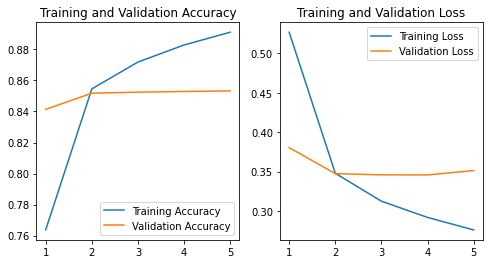

In [12]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 4-2. 1-D CNN

* 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 필터로 스캐닝하면서 필터 크기만큼의 단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식이다.

In [13]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [14]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 3s 6ms/step - loss: 0.5800 - accuracy: 0.6910 - val_loss: 0.4782 - val_accuracy: 0.7535
Epoch 2/5
208/208 [==============================] - 1s 5ms/step - loss: 0.4462 - accuracy: 0.7791 - val_loss: 0.4617 - val_accuracy: 0.7644
Epoch 3/5
208/208 [==============================] - 1s 5ms/step - loss: 0.4130 - accuracy: 0.7987 - val_loss: 0.4611 - val_accuracy: 0.7671
Epoch 4/5
208/208 [==============================] - 1s 5ms/step - loss: 0.3880 - accuracy: 0.8143 - val_loss: 0.4679 - val_accuracy: 0.7682
Epoch 5/5
208/208 [==============================] - 1s 5ms/step - loss: 0.3643 - accuracy: 0.8260 - val_loss: 0.4780 - val_accuracy: 0.7673


In [15]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4808 - accuracy: 0.7654
[0.48082205653190613, 0.7654454112052917]


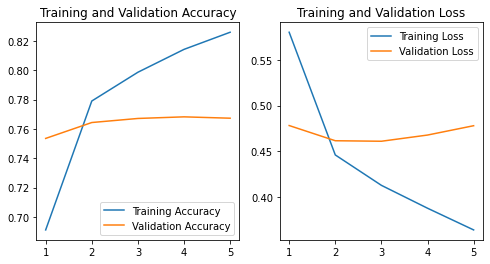

In [16]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 4-3. GlobalMaxPooling1D

* GlobalMaxPooling1D() 레이어 하나만 사용하는 방법은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이다.

In [17]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [18]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.6061 - accuracy: 0.7095 - val_loss: 0.4717 - val_accuracy: 0.8122
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.4018 - accuracy: 0.8348 - val_loss: 0.3729 - val_accuracy: 0.8382
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3356 - accuracy: 0.8596 - val_loss: 0.3549 - val_accuracy: 0.8450
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3029 - accuracy: 0.8748 - val_loss: 0.3522 - val_accuracy: 0.8473
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2796 - accuracy: 0.8872 - val_loss: 0.3552 - val_accuracy: 0.8469


In [19]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3659 - accuracy: 0.8439
[0.365894079208374, 0.8439489603042603]


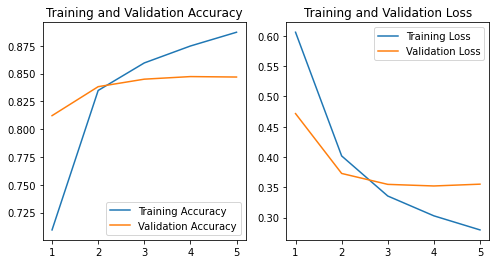

In [20]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5. 학습된 Embedding 레이어 분석

In [21]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [22]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("재미")  # 학습이 잘 되지 않아 별로 유사하지 않음

[('완전', 0.9664868712425232),
 ('적', 0.9540573954582214),
 ('터진', 0.9506309628486633),
 ('스타일', 0.9350130558013916),
 ('회복', 0.932081401348114),
 ('로마', 0.9317370653152466),
 ('보', 0.9293760061264038),
 ('스릴', 0.9290152192115784),
 ('올해', 0.9289511442184448),
 ('아기', 0.923599898815155)]

# 회고
* 모델을 만드는 것에 어려움이 있어 https://github.com/kec0130/AIFFEL-project/blob/main/exploration/E4_naver_movie_sentiment.ipynb 를 많이 참조했다.
* 오타 문제가 있지만 코드를 하나하나 뜯어보면서 쳐보는 연습이 필요하겠다.
* 어떤 방법을 써도 정확도에 문제가 있다. 자료 전처리에 문제가 있어보이는데 리뷰가 필요하다.
* 한국어 Word2Vec 임베딩 활용이 되지 않았다. 이유는 다시 찾아보고자 한다.